In [1]:
# 1) Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler, scale
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from scipy.signal import savgol_filter
from sklearn.linear_model import Ridge  
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RepeatedKFold

"""
Para que funcionen correctamente tienen que estar en formato numpy.array con shape (m ejemplos, n bandas)
CUANDO SE PASA UN EJEMPLO CERCIONARSE DE QUE SE numpy.array.shape (1,bandas seleccionadas)
"""

class SNV(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.test = '1'
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_ = X.copy()
        X_ = scale(X_, axis=1, with_mean=True, with_std=True, copy=True)
        return X_

class Derivada(BaseEstimator, TransformerMixin):
    def __init__(self, window, polyorder, derivada):
        self.window = window
        self.polyorder = polyorder
        self.derivada = derivada
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_ = X.copy()
        X_ = savgol_filter(X_, self.window, self.polyorder, self.derivada, axis=1)
        return X_

class SelectorBandas(BaseEstimator, TransformerMixin):
    """Introduce una lista de posiciones a seleccionar [0,3,5,...]. Devuelve (m_ejemplos, columnas)."""
    def __init__(self, posColumnasSel):
        self.posColumnasSel = posColumnasSel
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_ = X.copy()
        X_ = X_[:, self.posColumnasSel]
        return X_

class MEAN(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.test = '1'
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_ = X.copy()
        X_ = np.mean(X_, axis=0, keepdims=True)
        return X_

class ToArray(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_ = X.copy()
        X_ = X_.to_numpy()
        return X_


In [2]:
# 2) Cargar y transformar  ⚙️ EDITA la ruta/nombre de archivo y hojas
X_datos = pd.read_excel(r'./Brownie_NIR_datos-72.xlsx', sheet_name='X')  
Y_datos = pd.read_excel(r'./Brownie_Nir_datos-72.xlsx', sheet_name='Y')  

# A numpy
X_train = np.array(X_datos, dtype=float)
y_train = np.array(Y_datos).ravel().astype(float)   # 1D para Ridge

print("X_train:", X_train.shape, " | y_train:", y_train.shape)


X_train: (99, 123)  | y_train: (99,)


In [3]:
# ==== Imports ====
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter

from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error, r2_score

# ==== Hiperparámetros del modelo ====
ALPHA     = 0.5623413251903491
SG_WINDOW = 7      # impar
SG_POLY   = 2
SG_DERIV  = 1

# Índices (0-based) de bandas fiables (como en tu script original)
rangoFiable = np.arange(16, 123, 1)

class SNV(BaseEstimator, TransformerMixin):
    """Standard Normal Variate por fila (sin parámetros)."""
    def fit(self, X, y=None): return self
    def transform(self, X):
        A = X.values if hasattr(X, "values") else X
        mean = A.mean(axis=1, keepdims=True)
        std  = A.std(axis=1, keepdims=True)
        std[std == 0] = 1.0
        B = (A - mean) / std
        return pd.DataFrame(B, index=X.index, columns=X.columns) if hasattr(X, "iloc") else B

# ==== Pipeline de pretratamiento y modelo ====
pret = Pipeline([
    ("bandas", SelectorBandas(rangoFiable)),                 # selección primero
    ("snv",    SNV()),                                       # SNV por fila
    ("sg1_7",  Derivada(SG_WINDOW, SG_POLY, SG_DERIV)),      # SG 1ª deriv., ventana 7
    ("mc",     StandardScaler(with_std=False))               # mean-centering por columnas
])

modelo = Pipeline([
    ("pret",  pret),
    ("std",   StandardScaler()),                             # mean=0, std=1 antes de Ridge
    ("ridge", Ridge(alpha=ALPHA))
])

# ==== Entrenamiento (diagnóstico en calibración) ====
# Asume que ya existen X_train (DataFrame o ndarray) e y_train (array-like)
modeloentrenado = modelo.fit(X_train, y_train)
y_pred_train = modeloentrenado.predict(X_train).ravel()
rmse_train   = mean_squared_error(y_train, y_pred_train, squared=False)
r2_train     = r2_score(y_train, y_pred_train)
print(f"[Train] RMSE_train: {rmse_train:.5f} | R2_train: {r2_train:.5f}")

# ==== CV robusta por estimación OOF con RepeatedKFold (promedio por muestra) ====
rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123)
X = X_train
y = np.ravel(y_train).astype(float)

def _take(A, idx):
    return A.iloc[idx] if hasattr(A, "iloc") else A[idx]

n = X.shape[0]
y_pred_sum = np.zeros(n, dtype=float)
counts     = np.zeros(n, dtype=int)

for tr, te in rkf.split(X, y):
    m = clone(modelo)                 # ahora clone() funciona
    m.fit(_take(X, tr), y[tr])
    y_pred_te = m.predict(_take(X, te)).ravel()
    y_pred_sum[te] += y_pred_te
    counts[te]     += 1

# Promedio OOF por muestra (cada muestra puede ser predicha varias veces por las repeticiones)
y_pred_oof = y_pred_sum / counts

RMSE_OOF = mean_squared_error(y, y_pred_oof, squared=False)
R2_OOF   = r2_score(y, y_pred_oof)
print(f"[CV OOF RepeatedKFold] RMSE_OOF: {RMSE_OOF:.5f} | R2_OOF: {R2_OOF:.5f}")

# ==== Wrapper de producción (media del lote → modelo) ====
class MEAN(BaseEstimator, TransformerMixin):
    """Ejemplo de agregador que hace la media por columnas (ajústalo a tu implementación real)."""
    def fit(self, X, y=None): return self
    def transform(self, X):
        return np.atleast_2d(np.mean(X, axis=0))

modeloEmpresaProducto = Pipeline([
    ("media", MEAN()),
    ("modelo", modeloentrenado)
])

[Train] RMSE_train: 0.53608 | R2_train: 0.83661
[CV OOF RepeatedKFold] RMSE_OOF: 0.92703 | R2_OOF: 0.51140


In [4]:
# 4. Guardar el pipeline entrenado en un objeto joblib
joblib.dump(modeloEmpresaProducto, 'Brownie_Hum.joblib')
print('✅ Guardado: Brownie_Hum.joblib')

✅ Guardado: Brownie_Hum.joblib


n_reales: 99  | n_predichos: 99
RMSE_pred: 0.53608 | R2_pred: 0.83661


,Real,Predicho
0,15.14,15.450654
1,16.63,16.145674
2,16.24,16.016515
3,16.20,16.660030
4,15.69,16.008873


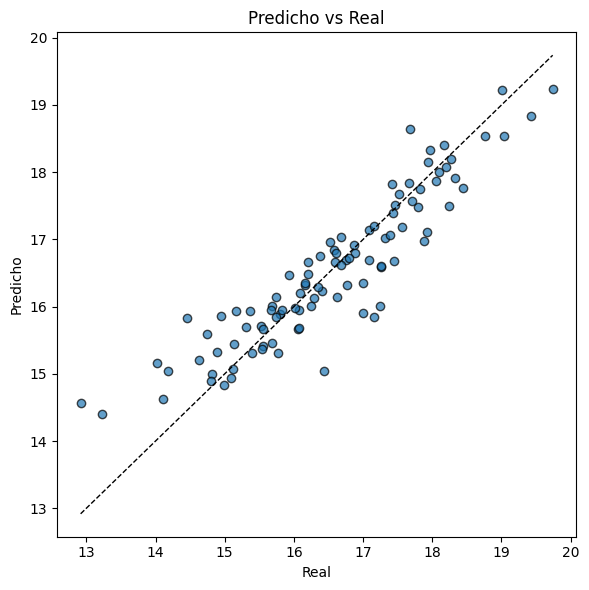

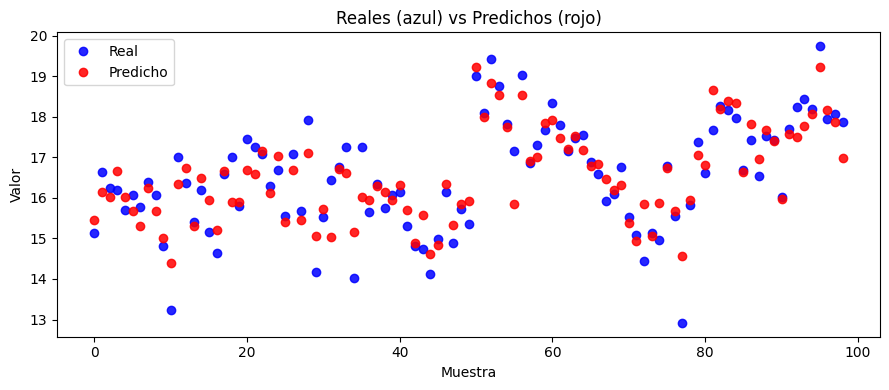

In [5]:
RUTA_MODELO = './Brownie_Hum.joblib'
RUTA_EXCEL  = r'./Brownie_Nir_datos-72.xlsx'  # por si no existen X_train / y_train

# 1) Cargar el wrapper de producción
wrapper = joblib.load(RUTA_MODELO)

# 2) Obtener el modelo interno (sin 'MEAN')
if hasattr(wrapper, "named_steps") and "modelo" in wrapper.named_steps:
    modelo_sin_mean = wrapper.named_steps["modelo"]    # <-- este SÍ predice una Y por fila de X
else:
    modelo_sin_mean = wrapper  # por si guardaste el pipeline sin wrapper

# 3) Reusar X_train / y_train si ya existen; si no, leer del Excel
if 'X_train' in globals() and 'y_train' in globals():
    X_pred = X_train
    y_true = np.ravel(y_train).astype(float)
else:
    X_datos = pd.read_excel(RUTA_EXCEL, sheet_name='X')
    Y_datos = pd.read_excel(RUTA_EXCEL, sheet_name='Y')
    X_pred  = np.array(X_datos, dtype=float)
    y_true  = np.array(Y_datos).ravel().astype(float)

# 4) Predicción FILA A FILA (sin promediar)
y_hat = modelo_sin_mean.predict(X_pred).ravel()

# Sanidad
print("n_reales:", len(y_true), " | n_predichos:", len(y_hat))  # deben coincidir

# 5) Métricas
rmse = mean_squared_error(y_true, y_hat, squared=False)
r2   = r2_score(y_true, y_hat)
print(f"RMSE_pred: {rmse:.5f} | R2_pred: {r2:.5f}")

# 6) Tabla Real/Predicho
resultados = pd.DataFrame({'Real': y_true, 'Predicho': y_hat})
display(resultados.head())

# 7A) Gráfico: Predicho vs Real (dispersión) con línea y=x
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_hat, alpha=0.7, edgecolors='black')
lims = [min(y_true.min(), y_hat.min()), max(y_true.max(), y_hat.max())]
plt.plot(lims, lims, linestyle='--', linewidth=1, color='black')
plt.xlabel('Real'); plt.ylabel('Predicho'); plt.title('Predicho vs Real')
plt.tight_layout(); plt.show()

# 7B) Gráfico por índice (azul = Real, rojo = Predicho)
plt.figure(figsize=(9, 4))
idx = np.arange(len(y_true))
plt.plot(idx, y_true, 'o', label='Real',  alpha=0.85, color='blue')
plt.plot(idx, y_hat,  'o', label='Predicho', alpha=0.85, color='red')
plt.xlabel('Muestra'); plt.ylabel('Valor'); plt.title('Reales (azul) vs Predichos (rojo)')
plt.legend(); plt.tight_layout(); plt.show()